## Cats and Dogs (2)
### Building powerful image classification models using very little data
By Francois Chollet: 
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import os
import sys
import numpy as np
import numpy.random as nr

import theano
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

print 'Keras ', keras.__version__
print 'Theano', theano.__version__


Using Theano backend.


Keras  1.2.0
Theano 0.8.2


## Dataset

O dataset foi obtido de uma competição do Kaggle, https://www.kaggle.com/c/dogs-vs-cats/data.
Utilizaremos neste exemplo as primeiras 1000 imagens de gatos e cachorros como conjunto de treinamento, totalizando 2000 imagens. Para validação usamos as 400 imagens seguintes de cachorros e gatos. O nosso dataset está organizado da seguinte forma:

    CatsDogs/
        train/
            dogs/
                dog.0.jpg
                dog.1.jpg
                ...
                dog.999.jpg
            cats/
                cat.0.jpg
                cat.1.jpg
                ...
                cat.999.jpg
        validation/
            dogs/
                dog.1000.jpg
                dog.1001.jpg
                ...
                dog.1399.jpg
            cats/
                cat.1000.jpg
                cat.1001.jpg
                ...
                cat.1399.jpg
            

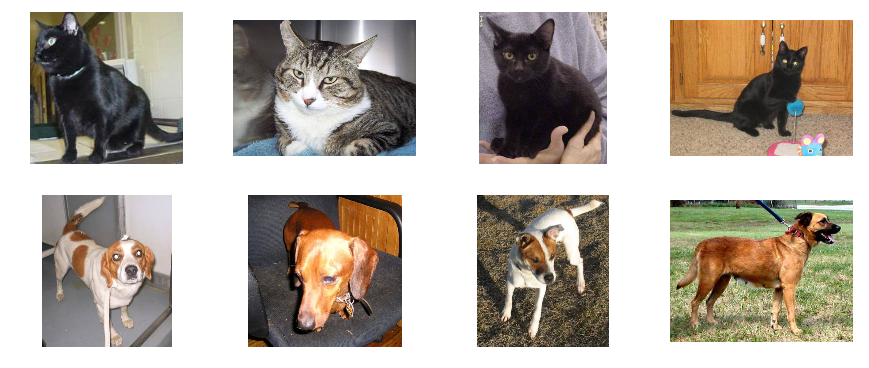

In [3]:
train_data_dir = '/root/CatsDogs/train'
validation_data_dir = '/root/CatsDogs/validation'
nb_train_samples = 2000
nb_validation_samples = 800

fig = plot.figure(figsize=(15,6))
for i, j in enumerate(nr.randint(0, 1000, 4)):
    fig.add_subplot(2,4, i+1)
    img = plot.imread('{}/cats/cat.{}.jpg'.format(train_data_dir, j))
    plot.imshow(img)
    plot.axis('off')
    
    fig.add_subplot(2,4, i+5)
    img = plot.imread('{}/dogs/dog.{}.jpg'.format(train_data_dir, j))
    plot.imshow(img)    
    plot.axis('off')


In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## VGG Features

[![VGG Network Layers](https://blog.keras.io/img/imgclf/vgg16_original.png)]()

In [3]:
def get_and_save_vgg_features(trn_feat_fn, val_feat_fn):
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(3, img_height, img_width))
    train_features = vgg.predict_generator(train_generator, nb_train_samples)
    np.save(open(trn_feat_fn, 'w'), train_features)
    validation_features = vgg.predict_generator(validation_generator, nb_validation_samples)
    np.save(open(val_feat_fn, 'w'), validation_features)
    return train_features, validation_features

trn_feat_fn = 'vgg16_150x150_features_train.npy'
val_feat_fn = 'vgg16_150x150_features_valid.npy'

if not os.path.isfile(trn_feat_fn):
    train_features, validation_features = get_and_save_vgg_features(trn_feat_fn, val_feat_fn)
else:
    train_features = np.load(open(trn_feat_fn))
    validation_features = np.load(open(val_feat_fn))
    
train_labels = np.array([0] * 1000 + [1] * 1000)
validation_labels = np.array([0] * 400 + [1] * 400)

## Modelo
A rede neural utilizada é especificada a seguir.

In [6]:
class LeNet:
    @staticmethod
    def build(img_width, img_height):
        model = Sequential()
        model.add(Flatten(input_shape=train_features.shape[1:]))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        return model

LeNet.build(img_width, img_height).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 8192)          0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 256)           2097408     flatten_1[0][0]                  
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             257         dropout_1[0][0]                  
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_______________

In [15]:
os.sys.path.append('../src/')
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

model_name = 'cats_dogs_vgg'

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = LeNet.build(img_width, img_height)
    
    # History, checkpoint, earlystop, plot losses:
    histo = TrainingPlotter(n=1, filepath=model_name, patience=15)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, histo = load_model_and_history(model_name)


[INFO] creating model...
[INFO] compiling model...


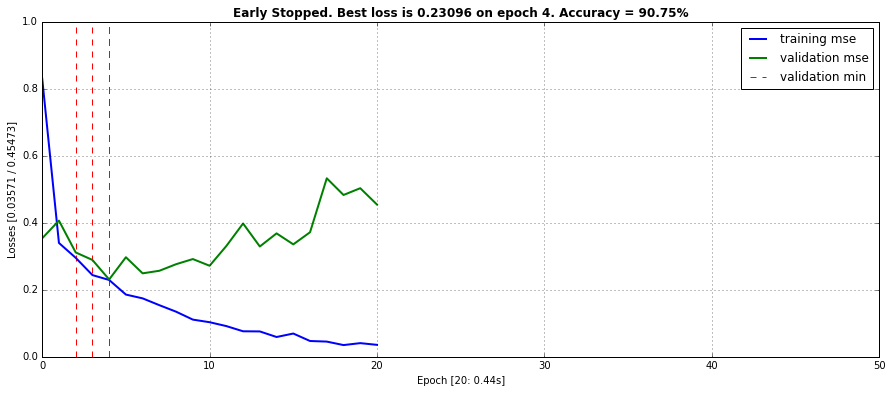

In [16]:
if 1:
    nb_epoch = 50
    ploss = 1.0

    nepochs = nb_epoch - histo.get_nepochs()

    fig = plot.figure(figsize=(15,6))
    plot.ylim(0.0, ploss)
    plot.xlim(0, nb_epoch)
    plot.grid(True)

    if nepochs > 0:
        print("[INFO] training...")
        try:
            model.fit(train_features, train_labels,
                      nb_epoch=nepochs, batch_size=32, verbose=0,
                      callbacks=[histo],
                      validation_data=(validation_features, validation_labels))
        except KeyboardInterrupt:
            pass
    else:
        print("[INFO] plotting...")
        # plot history


In [18]:
print("[INFO] loading model...")
model, histo = load_model_and_history(model_name)
print("[INFO] evaluating...")
loss, accuracy = model.evaluate(validation_features, validation_labels, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


[INFO] loading model...
[INFO] evaluating...
800/800 [==============================] - 0s     
[INFO] accuracy: 90.75%
